In [15]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from dtaidistance import dtw
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import fcluster

import utils
import predictive_clustering
import predictive_plots

### Prediction on Rating0 differenciated by Match and Emotion on RETOS & BEBRASK using Time Series


In [16]:
#Importing the joined data from RETOS & BEBRASK that has a time series structure
data = pd.read_excel("RETOS_BEBRASK_Rating0_Time_Series.xlsx")
data

,Subject ID,Happy_0_0,Happy_0_1,Happy_0_2,Happy_0_3,Happy_0_4,Happy_0_5,Happy_1_0,Happy_1_1,Happy_1_2,...,Fear_0_5,Fear_1_0,Fear_1_1,Fear_1_2,Fear_1_3,Fear_1_4,Fear_1_5,Fear_1_6,Fear_1_7,Fear_1_8
0,PREDWELL_RETOS-1001-1,4,1,1,1,1,1,4,4,4,...,3,4,1,3,2,3,4,3,3,4
1,PREDWELL_RETOS-1002-1,1,1,3,1,1,1,3,4,4,...,1,3,1,3,4,3,4,2,3,4
2,PREDWELL_RETOS-1003-1,1,1,1,1,1,1,3,3,4,...,2,2,2,3,2,2,2,1,3,3
3,PREDWELL_RETOS-1004-1,1,1,3,3,2,1,1,4,2,...,2,2,4,3,1,3,3,2,1,3
4,PREDWELL_RETOS-1005-1,1,1,1,1,2,1,4,3,4,...,1,2,2,2,3,3,3,4,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,PREDWELL_RETOS-5-1,2,2,1,1,1,1,3,4,4,...,1,1,1,4,2,4,3,3,2,2
145,PREDWELL_RETOS-6-1,1,2,1,1,1,1,3,3,4,...,1,2,2,2,4,2,3,2,4,4
146,PREDWELL_RETOS-7-1,1,1,1,1,1,1,3,4,2,...,4,4,1,2,4,4,1,4,4,1
147,PREDWELL_RETOS-8-1,1,1,1,1,1,1,4,4,1,...,3,3,3,4,3,2,4,2,1,3


In [17]:
#Importing and concatenating the scales raw data from RETOS & BEBRASK
scales_BEBRASK = pd.read_excel("../Datasets/RETOS_scales.xlsx")
scales_RETOS = pd.read_excel("../Datasets/BEBRASK_scales.xlsx")
scales = pd.concat([scales_BEBRASK, scales_RETOS])

#Removing PREDWELL_RETOS-307-1 that has different number of answers per emotion, and converting columns to numerical and coercing errors to NaN.
scales = scales.query("EPRIME_CODE != 'PREDWELL_RETOS-307-1'")
cols = scales.columns
#The first three columns are SUBJECT_CODE, EPRIME_CODE and Gender, which are non-numerical
scales[cols[3:]] = scales[cols[3:]].apply(pd.to_numeric, errors='coerce')
scales.info()


<class 'pandas.core.frame.DataFrame'>
Index: 149 entries, 0 to 54
Data columns (total 53 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SUBJECT_CODE   149 non-null    object 
 1   EPRIME_CODE    149 non-null    object 
 2   Gender         94 non-null     object 
 3   Age            149 non-null    int64  
 4   PA             149 non-null    int64  
 5   NA.            149 non-null    int64  
 6   ERQ_CR         149 non-null    float64
 7   ERQ_ES         149 non-null    float64
 8   UPPSP_NU       149 non-null    int64  
 9   UPPSP_PU       149 non-null    int64  
 10  UPPSP_SS       149 non-null    int64  
 11  UPPSP_PMD      148 non-null    float64
 12  UPPSP_PSV      149 non-null    int64  
 13  BIS            149 non-null    int64  
 14  BAS_RR         149 non-null    int64  
 15  BAS_D          149 non-null    int64  
 16  BAS_FS         149 non-null    int64  
 17  TEPS_AF        149 non-null    int64  
 18  TEPS_CF        1

Firstly, the time series have been structured based on the evoked emotion and on the match, as it allows to compare exactly how each individual answered for the same task in the same time frame (for the specific scenario). Therefore we split the time series into different dataframes that contain each type of scenario for all the individuals.

In [18]:
#Splitting the time series based on the evoked emotion and if it is match or not
temporal_happy_0 = data[["Subject ID","Happy_0_0","Happy_0_1","Happy_0_2","Happy_0_3","Happy_0_4","Happy_0_5"]]
temporal_happy_1 = data[["Subject ID","Happy_1_0","Happy_1_1","Happy_1_2","Happy_1_3","Happy_1_4","Happy_1_5","Happy_1_6","Happy_1_7","Happy_1_8"]]
temporal_fear_0 = data[["Subject ID","Fear_0_0","Fear_0_1","Fear_0_2","Fear_0_3","Fear_0_4","Fear_0_5"]]
temporal_fear_1 = data[["Subject ID","Fear_1_0","Fear_1_1","Fear_1_2","Fear_1_3","Fear_1_4","Fear_1_5","Fear_1_6","Fear_1_7","Fear_1_8"]]
temporal_sad_0 = data[["Subject ID","Sad_0_0","Sad_0_1","Sad_0_2","Sad_0_3","Sad_0_4","Sad_0_5"]]
temporal_sad_1 = data[["Subject ID","Sad_1_0","Sad_1_1","Sad_1_2","Sad_1_3","Sad_1_4","Sad_1_5","Sad_1_6","Sad_1_7","Sad_1_8"]]

For BEBRASK and RETOS not all metrics from scales are evaluated. We already create a list containing the groups of metrics that are evaluated for these datasets to make the evaluation easier going forwards.

In [19]:
#Grouping the metrics that will be evaluated from scales for the BEBRASK and RETOS dataset (as the rest were no used
#or contain to many NaNs
PANAS = ["PA", "NA."]
ERQ = ["ERQ_CR", "ERQ_ES"]
UPPSP = ["UPPSP_NU", "UPPSP_PU", "UPPSP_SS", "UPPSP_PMD", "UPPSP_PSV"]
BIS_BAS = ["BIS", "BAS_D", "BAS_RR", "BAS_FS"]
TEPS = ["TEPS_AF", "TEPS_CF"]
SHS = ["SHS"]
FS = ["FS"]
LOTR = ["LOT_R"]
RRQ = ["RRQ_Rum", "RRQ_Ref"]
ASI3 = ["ASI_P", "ASI_C", "ASI_S"]
SPQ = ["SPQ", "SPQ_IR"]
MSSB = ["MSSB_POS", "MSSB_NEG", "MSSB_DES"]

list_metrics = [PANAS, ERQ, UPPSP, BIS_BAS, TEPS, SHS, FS, LOTR, RRQ, ASI3, SPQ, MSSB]

## Hierarchical Clustering using Dynamic Time Warping
Dynamic Time Warping (DTW) is an algorithm that allows to evaluate the similarity between different time series that do not necessarily have the same speed. This makes it easier to evaluate the non match scenarios, as there are different emotions involved and they are not shown in the same order. By using DTW, we attenuate this possible problem, as it takes into account not only the points from the same time stamp when computing the distance.

Hierarchical Clustering suits the problem as is the most predominant algorithm used for Social Networks, and we want to create the groups based on the similarity, we do not need to set the number of clusters and it is easy to visualize the different clusters. It is also good for small datasets.

#### Happy Match

#### Happy Match


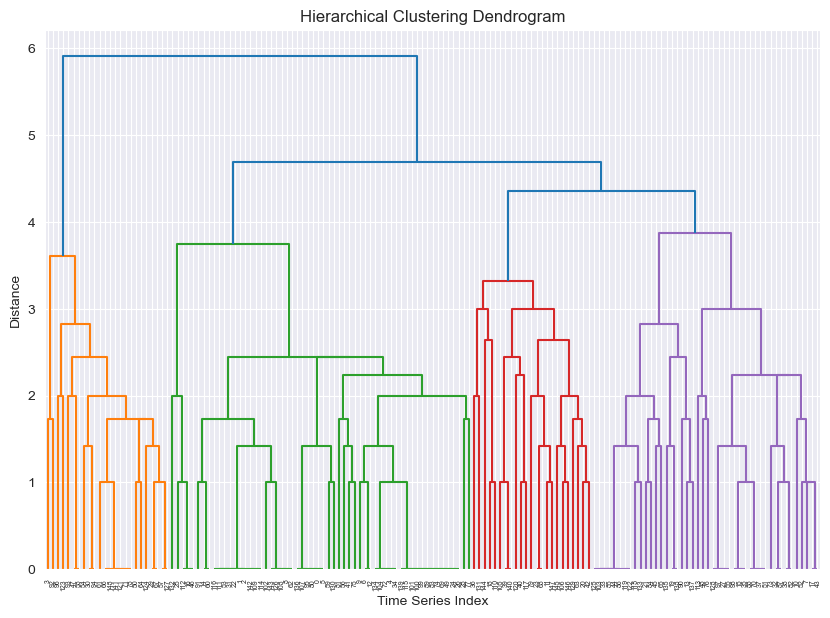

In [20]:
ts_data = temporal_happy_1.drop(["Subject ID"], axis=1).to_numpy()
params = {'method':'complete'}
Z = predictive_clustering.hierarchical_clustering_ts_linkage([ts_data],dtw.distance_matrix_fast,params=params)

4 clusters can be observed from the dendrogram using the distance of 4 between clusters the cut-off. Given the psychological context of the problem, we should aim for a low number of clusters that gives us a more general view from the predictive processing data, as increasing the number of clusters would make the clusters "overfitted".

In [21]:
params_clust = {'Z':Z,'t':4,'criterion':'maxclust'}
cluster_data_happy1 =  predictive_clustering.clustering(temporal_happy_1.copy(),algorithm = fcluster,params = params_clust)
print("Silhouette score:",silhouette_score(data.drop("Subject ID",axis=1),cluster_data_happy1["clusters"],metric="manhattan"))
print("Davies-Bouldin score:",davies_bouldin_score(data.drop("Subject ID",axis=1),cluster_data_happy1["clusters"]))

#TODO: Change the data used for the evaluation of the Silhouette score and Davies-Bouldin score, use the raw data consisting from avg pred, dif match and correlation. It will also allow to see which cut-off might perform better

Silhouette score: 0.007404144429389919
Davies-Bouldin score: 6.016899429795696


In [22]:
#Creation of the word document containing the boxplots and table with some metrics
name_output = f"time_series_happy_match.docx"
new_data = pd.merge(scales.copy(),cluster_data_happy1.copy(), right_on='Subject ID', left_on='EPRIME_CODE')
new_data.drop("Subject ID",axis=1,inplace=True)

df = utils.filter_data(new_data)

utils.create_word(df,list_metrics, name_output)

In [23]:
output_name = f'Clusters_TimeSeries/time_series_predictive_processing_happy_match_clusters.xlsx'
utils.export_clusters_df(cluster_data_happy1.copy(),output_name)


We can observe that cluster 2 and 4 have significantly more subjects than clusters 1 and 3. Nonetheless, looking at the boxplots we can only see that cluster 2 has a higher average score for the happy scenarios that match than the rest of the clusters, for the rest of the emotions the scores are very similar. Therefore, it does not look as a good clustering, as it does not bring much information.

In [24]:
#Length cluster
predictive_clustering.length_cluster(cluster_data_happy1)

,Cluster,Count
0,1,24
1,2,58
2,3,23
3,4,44


In [25]:
#Means tasks
utils.create_mean_tasks(data,cluster_data_happy1.copy())


,Cluster,Happy_0,Happy_1,Sad_0,Sad_1,Fear_0,Fear_1
0,2.0,1.229885,3.626437,1.744253,2.888889,1.853448,2.758621
1,1.0,1.236111,3.162037,1.694444,2.541667,1.715278,2.606481
2,4.0,1.204545,3.383838,1.731061,2.729798,1.795455,2.734848
3,3.0,1.166667,3.246377,1.717391,2.782609,1.789855,2.661836


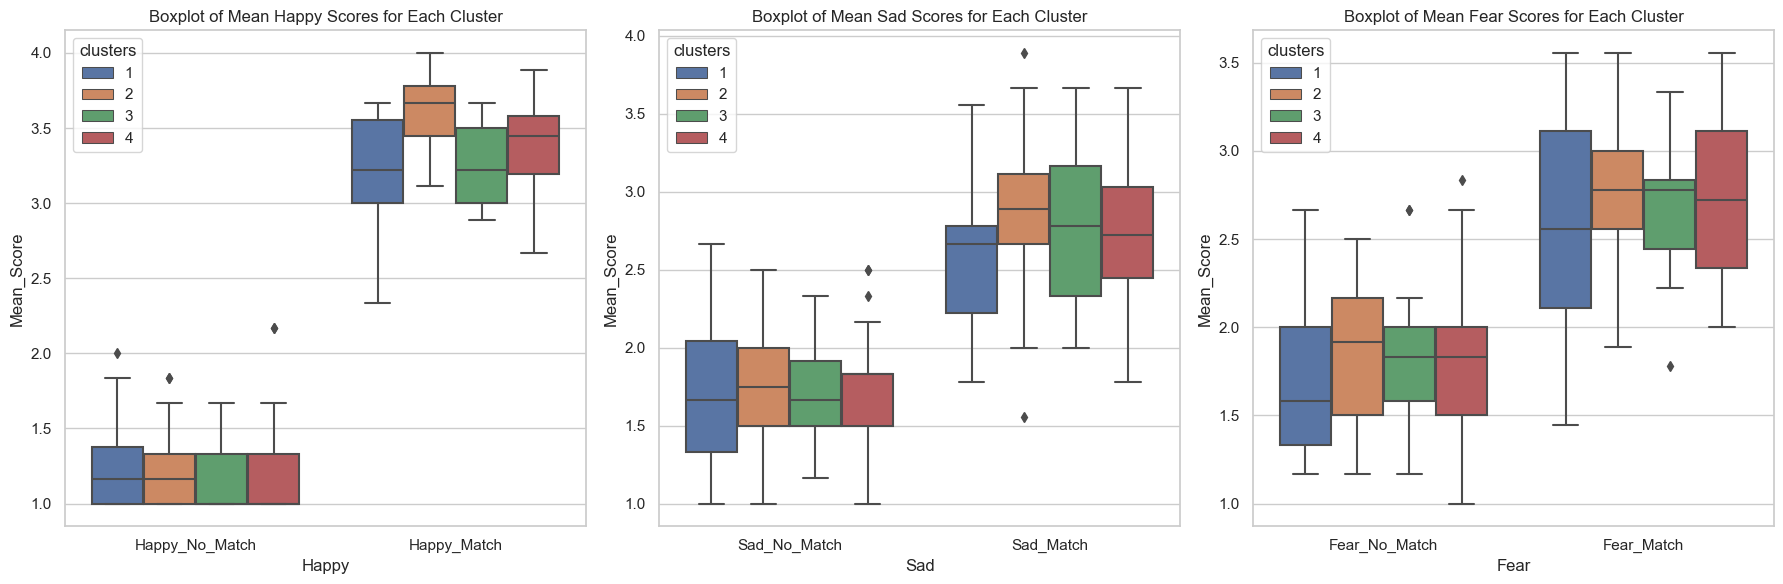

In [26]:
#Boxplots tasks
predictive_plots.create_boxplot_emotions(data,cluster_data_happy1)

#### Happy Non Match


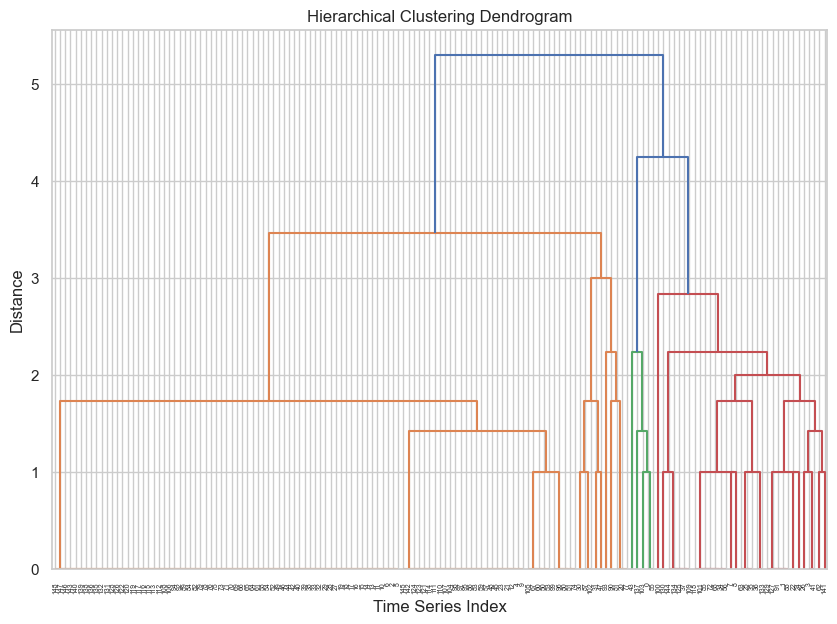

In [27]:
ts_data = temporal_happy_0.drop(["Subject ID"], axis=1).to_numpy()
Z = predictive_clustering.hierarchical_clustering_ts_linkage([ts_data],dtw.distance_matrix_fast,params=params)


3 clusters can be observed from the dendrogram using the distance of 4 between clusters the cut-off. It looks as one cluster contains most of the subjects, meaning that most individuals answered very similar for this specific scenario.

In [28]:
params_clust = {'Z':Z,'t':3,'criterion':'maxclust'}
cluster_data_happy0 =  predictive_clustering.clustering(temporal_happy_0.copy(),algorithm = fcluster,params = params_clust)

print("Silhouette score:",silhouette_score(data.drop("Subject ID",axis=1),cluster_data_happy0["clusters"],metric="manhattan"))
print("Davies-Bouldin score:",davies_bouldin_score(data.drop("Subject ID",axis=1),cluster_data_happy0["clusters"]))

#TODO: Change the data used for the evaluation of the Silhouette score and Davies-Bouldin score, use the raw data consisting from avg pred, dif match and correlation. It will also allow to see which cut-off might perform better

Silhouette score: 0.02044712570646001
Davies-Bouldin score: 6.376322824837078


In [29]:
#Creation of the word document containing the boxplots and table with some metrics
name_output = f"time_series_happy_no_match.docx"
new_data = pd.merge(scales.copy(), cluster_data_happy0.copy(), right_on='Subject ID', left_on='EPRIME_CODE')
new_data.drop("Subject ID", axis=1, inplace=True)

df = utils.filter_data(new_data)

utils.create_word(df, list_metrics, name_output)


In [30]:
output_name = f'Clusters_TimeSeries/time_series_predictive_processing_happy_non_match_clusters.xlsx'
utils.export_clusters_df(cluster_data_happy0.copy(),output_name)


CLuster 1 contains most of the subjects, whereas cluster 2 is very specific. We can see that cluster 2 has consistently a higher score for the non-matching scenarios, and also for matching scenarios (having a larger gap for negative emotions, which suggests that is a well distinctive group compared to the other two clusters. For cluster 3 we can see that has a higher score for the non matching happy scenario and also for the rest of the scenarios compared to cluster 1, but it is not significant.

With all this said, cluster number 2 should be inspected in order to see if there is a particular reason of why exists this difference.


In [31]:
#Length cluster
predictive_clustering.length_cluster(cluster_data_happy0)


,Cluster,Count
0,1,111
1,2,5
2,3,33


In [32]:
#Means tasks
utils.create_mean_tasks(data,cluster_data_happy0)


,Cluster,Happy_0,Happy_1,Sad_0,Sad_1,Fear_0,Fear_1
0,2.0,1.633333,3.577778,1.966667,3.066667,2.100000,2.977778
1,3.0,1.444444,3.457912,1.772727,2.777778,1.868687,2.801347
2,1.0,1.126126,3.403403,1.704204,2.753754,1.771772,2.673674


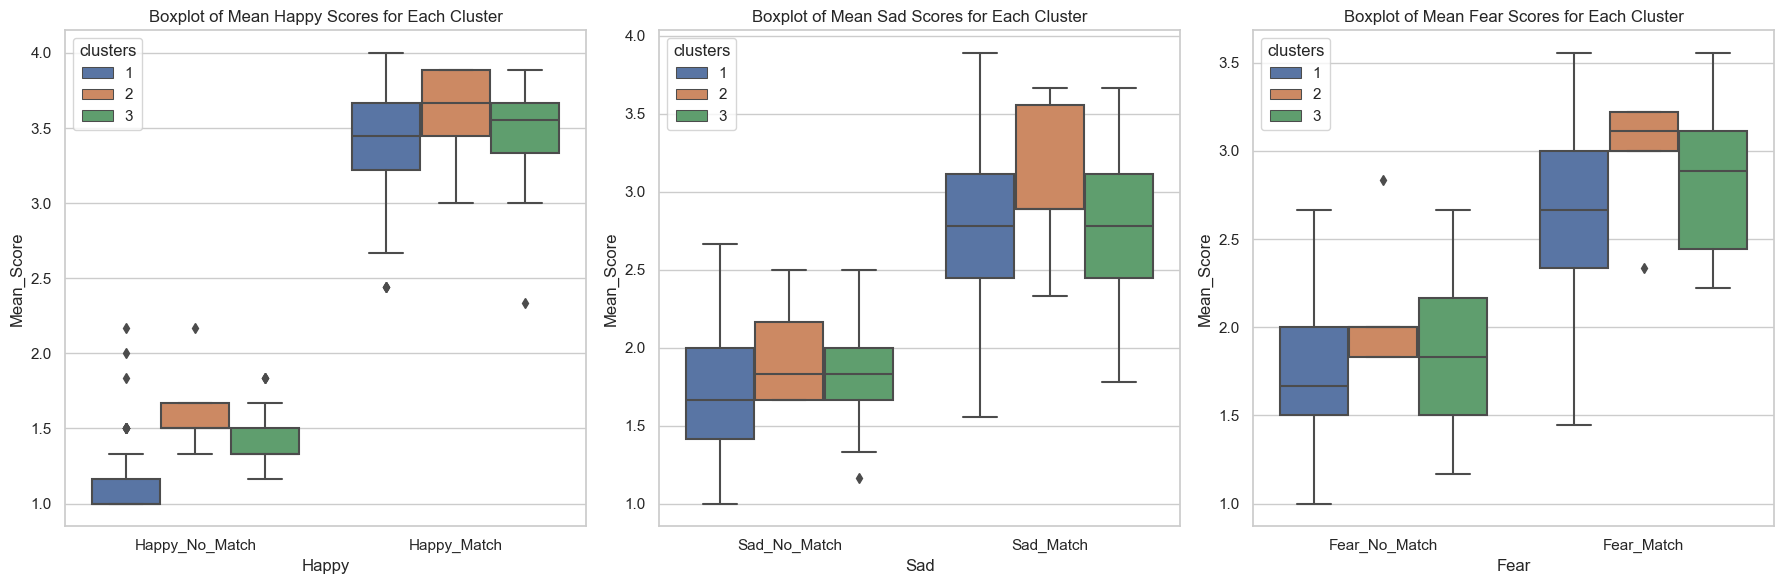

In [33]:
#Boxplots tasks
predictive_plots.create_boxplot_emotions(data,cluster_data_happy0)


#### Fear Match

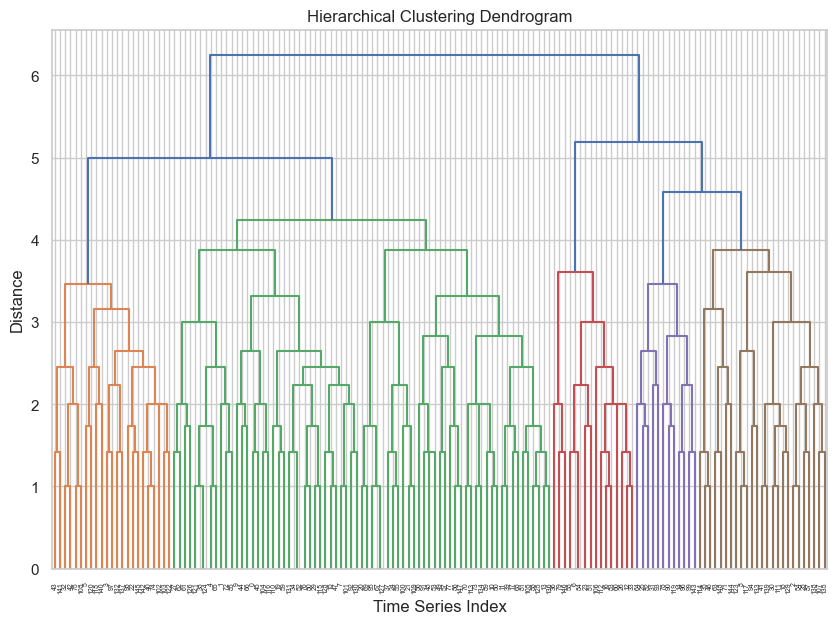

In [34]:
ts_data = temporal_fear_1.drop(["Subject ID"], axis=1).to_numpy()
Z = predictive_clustering.hierarchical_clustering_ts_linkage([ts_data],dtw.distance_matrix_fast,params=params)

5  clusters can be observed from the dendrogram using the distance of 4 between clusters the cut-off (if we lowered it a bit we would have 6 clusters, dividing the green cluster into two).

In [35]:
params_clust = {'Z':Z,'t':5,'criterion':'maxclust'}
cluster_data_fear1 =  predictive_clustering.clustering(temporal_fear_1.copy(),fcluster,params = params_clust)

print("Silhouette score:",silhouette_score(data.drop("Subject ID",axis=1),cluster_data_fear1["clusters"],metric="manhattan"))
print("Davies-Bouldin score:",davies_bouldin_score(data.drop("Subject ID",axis=1),cluster_data_fear1["clusters"]))

#TODO: Change the data used for the evaluation of the Silhouette score and Davies-Bouldin score, use the raw data consisting from avg pred, dif match and correlation. It will also allow to see which cut-off might perform better

Silhouette score: 0.0072837152120460895
Davies-Bouldin score: 4.851453784363998


In [36]:
name_output = f"time_series_fear_match.docx"
new_data = pd.merge(scales.copy(), cluster_data_fear1.copy(), right_on='Subject ID', left_on='EPRIME_CODE')
new_data.drop("Subject ID", axis=1, inplace=True)

df = utils.filter_data(new_data)

utils.create_word(df, list_metrics, name_output)

In [37]:
output_name = f'Clusters_TimeSeries/time_series_predictive_processing_fear_match_clusters.xlsx'
utils.export_clusters_df(cluster_data_fear1.copy(),output_name)


Cluster number 2 is the predominant cluster, the one that groups most of the individuals. The most significant observation that can be made from this clusters is that the cluster number 4 and 5 have a lower predictability score for the negative emotions that match

In [38]:
predictive_clustering.length_cluster(cluster_data_fear1)

,Cluster,Count
0,1,23
1,2,73
2,3,16
3,4,12
4,5,25


In [39]:
#Means tasks
utils.create_mean_tasks(data,cluster_data_fear1)


,Cluster,Happy_0,Happy_1,Sad_0,Sad_1,Fear_0,Fear_1
0,2.0,1.203196,3.453577,1.778539,2.858447,1.764840,2.911720
1,5.0,1.220000,3.311111,1.553333,2.680000,1.820000,2.275556
2,1.0,1.260870,3.483092,1.731884,2.748792,1.971014,2.705314
3,3.0,1.145833,3.465278,1.708333,2.881944,1.802083,2.916667
4,4.0,1.263889,3.277778,1.805556,2.305556,1.694444,2.148148


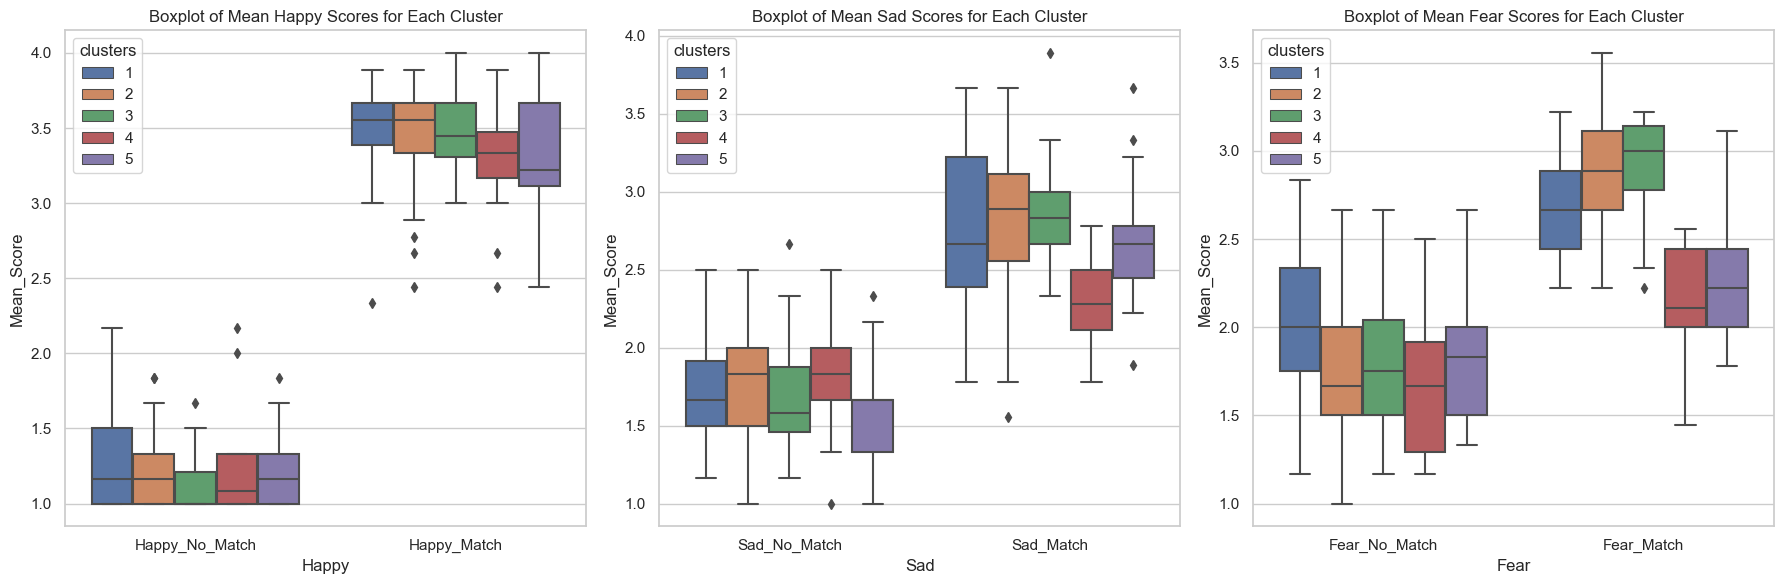

In [40]:
#Boxplots tasks
predictive_plots.create_boxplot_emotions(data,cluster_data_fear1)

#### Fear No Match

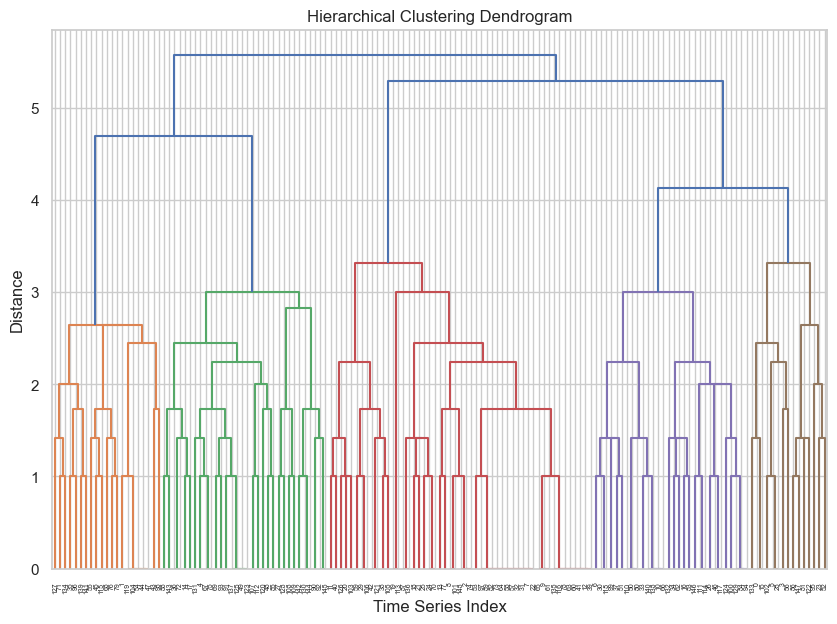

In [41]:
ts_data = temporal_fear_0.drop(["Subject ID"], axis=1).to_numpy()
Z = predictive_clustering.hierarchical_clustering_ts_linkage([ts_data],dtw.distance_matrix_fast,params=params)


5  clusters can be observed from the dendrogram using the distance of 4 between clusters the cut-off. 


In [42]:
params_clust = {'Z':Z,'t':5,'criterion':'maxclust'}
cluster_data_fear0 =  predictive_clustering.clustering(temporal_fear_0.copy(),fcluster,params = params_clust)

print("Silhouette score:",silhouette_score(data.drop("Subject ID",axis=1),cluster_data_fear0["clusters"],metric="manhattan"))
print("Davies-Bouldin score:",davies_bouldin_score(data.drop("Subject ID",axis=1),cluster_data_fear0["clusters"]))

#### Fear No Match

Silhouette score: 0.01617464300874908
Davies-Bouldin score: 4.520371634105031


In [43]:
name_output = f"time_series_fear_no_match.docx"
new_data = pd.merge(scales.copy(), cluster_data_fear0.copy(), right_on='Subject ID', left_on='EPRIME_CODE')
new_data.drop("Subject ID", axis=1, inplace=True)

df = utils.filter_data(new_data)

utils.create_word(df, list_metrics, name_output)

In [44]:
output_name = f'Clusters_TimeSeries/time_series_predictive_processing_fear_no_match_clusters.xlsx'
utils.export_clusters_df(cluster_data_fear0.copy(),output_name)


The size of the clusters are pretty similar, except for the biggest one, cluster number 3. The only meaningful differences can be seen in the scenarios where fear is evoked and is non-matching. We can see a gap of nearly 1 point between the highest (cluster 5) and the lower (cluster 3), which also are the smallest and biggest cluster respectively. Nonetheless, it does look like a good clustering approach as the rest of the scores for the other scenarios are very similar.

In [45]:
predictive_clustering.length_cluster(cluster_data_fear0)

,Cluster,Count
0,1,21
1,2,32
2,3,51
3,4,30
4,5,15


In [46]:
#Means tasks
utils.create_mean_tasks(data,cluster_data_fear0)


,Cluster,Happy_0,Happy_1,Sad_0,Sad_1,Fear_0,Fear_1
0,5.0,1.244444,3.437037,1.777778,2.674074,2.311111,2.903704
1,1.0,1.269841,3.354497,1.738095,2.899471,2.039683,2.714286
2,3.0,1.160131,3.435730,1.653595,2.642702,1.444444,2.636166
3,2.0,1.229167,3.378472,1.822917,2.871528,1.901042,2.722222
4,4.0,1.233333,3.481481,1.722222,2.833333,1.894444,2.733333


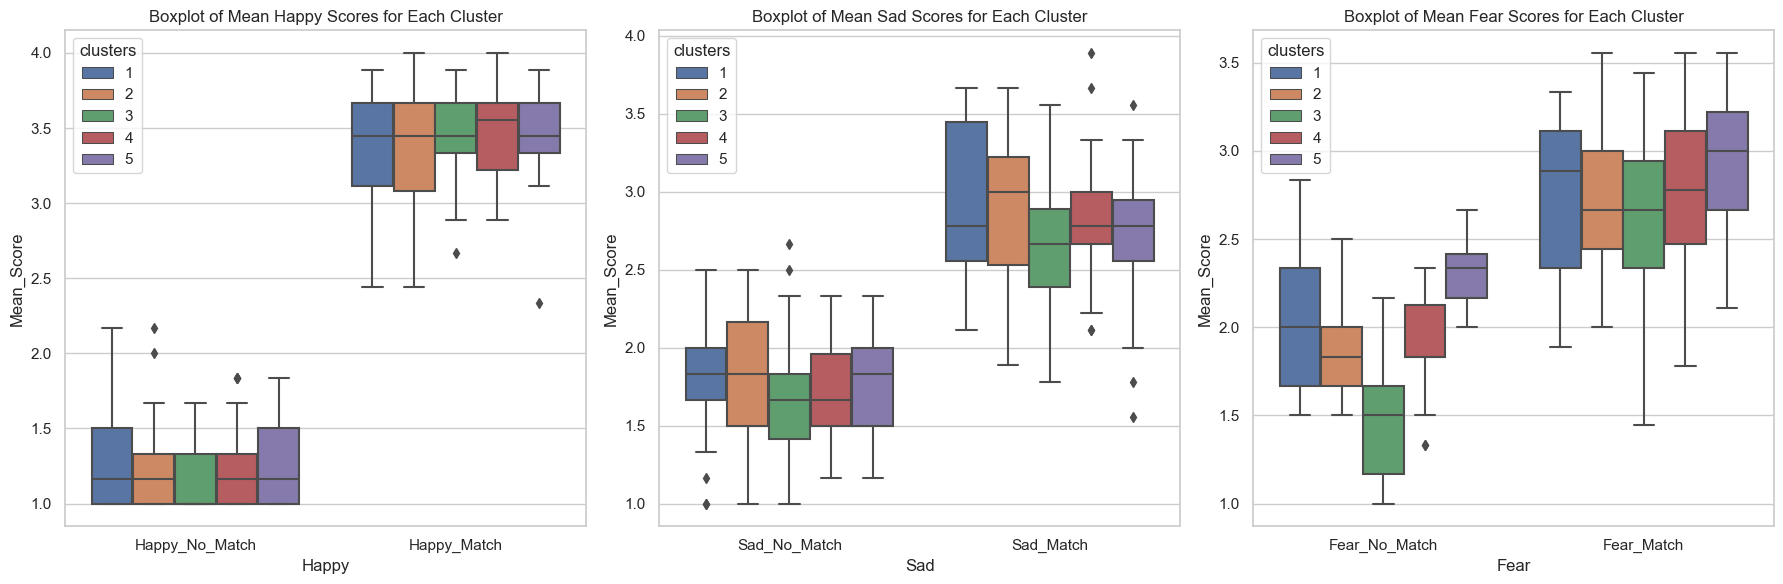

In [47]:
#Boxplots tasks
predictive_plots.create_boxplot_emotions(data,cluster_data_fear0)


#### Sad Match

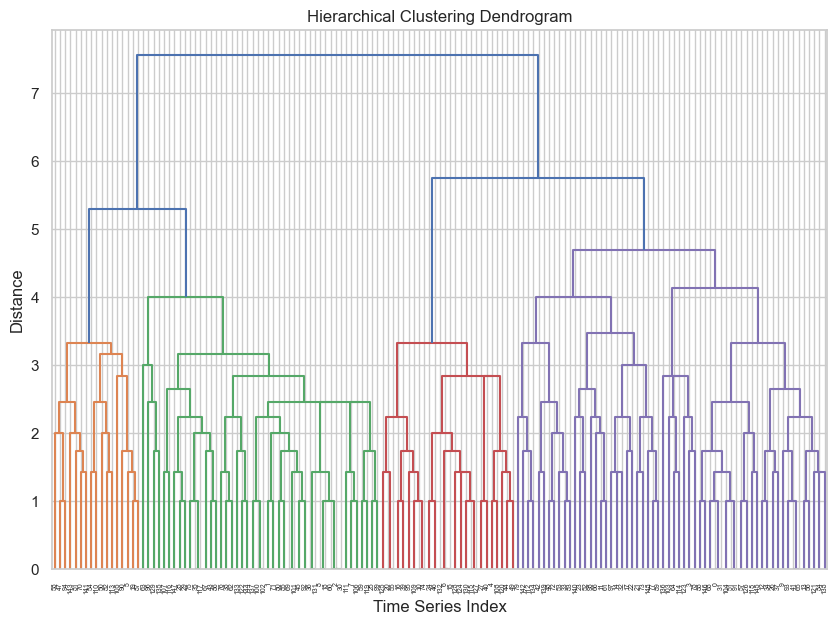

In [48]:
ts_data = temporal_sad_1.drop(["Subject ID"], axis=1).to_numpy()
params = {'method':'complete'}
Z = predictive_clustering.hierarchical_clustering_ts_linkage([ts_data],dtw.distance_matrix_fast,params=params)

5 clusters can be seen if we use 4 as the cut-off distance (in the plot the cut-off is around 4.5, and that is why 4 clusters are represented). We keep using 4 as a cut-off as it was the same value for the other clusters already created.

In [49]:
params_clust = {'Z':Z,'t':5,'criterion':'maxclust'}
cluster_data_sad1 =  predictive_clustering.clustering(temporal_sad_1.copy(),fcluster,params = params_clust)

print("Silhouette score:",silhouette_score(data.drop("Subject ID",axis=1),cluster_data_sad1["clusters"],metric="manhattan"))
print("Davies-Bouldin score:",davies_bouldin_score(data.drop("Subject ID",axis=1),cluster_data_sad1["clusters"]))



Silhouette score: 0.005232434713118937
Davies-Bouldin score: 5.21006577473307


In [50]:
name_output = f"time_series_sad_match.docx"
new_data = pd.merge(scales.copy(), cluster_data_sad1.copy(), right_on='Subject ID', left_on='EPRIME_CODE')
new_data.drop("Subject ID", axis=1, inplace=True)

df = utils.filter_data(new_data)

utils.create_word(df, list_metrics, name_output)

In [51]:
output_name = f'Clusters_TimeSeries/time_series_predictive_processing_sad_match_clusters.xlsx'
utils.export_clusters_df(cluster_data_sad1.copy(),output_name)


The size of the clusters are quite similar, although there is a significant gap between the largest (cluster 2) and the smallest (cluster 1). It can be observed that cluster 1 gives a lower score of predictability to negative emotions (specifically on scenarios of sadness where the face matches, which is the feature used to clusterize). This can suggest that the subjects from this cluster give a lower score to negative emotions. On the other hand, cluster 3 is the opposite, giving the highest score for each of the negative emotions scenarios (having the biggest gap in the matching scenarios for sadness and fear). This would suggest that the subjects from this group tend to rate higher, regardless from the emotion.

In [52]:
predictive_clustering.length_cluster(cluster_data_sad1)

,Cluster,Count
0,1,17
1,2,46
2,3,26
3,4,28
4,5,32


In [53]:
#Means tasks
utils.create_mean_tasks(data,cluster_data_sad1)


,Cluster,Happy_0,Happy_1,Sad_0,Sad_1,Fear_0,Fear_1
0,5.0,1.255208,3.368056,1.614583,2.572917,1.651042,2.743056
1,2.0,1.271739,3.388889,1.721014,2.756039,1.898551,2.637681
2,3.0,1.134615,3.641026,1.884615,3.410256,1.955128,2.957265
3,1.0,1.254902,3.241830,1.705882,2.209150,1.656863,2.529412
4,4.0,1.119048,3.440476,1.738095,2.761905,1.773810,2.682540


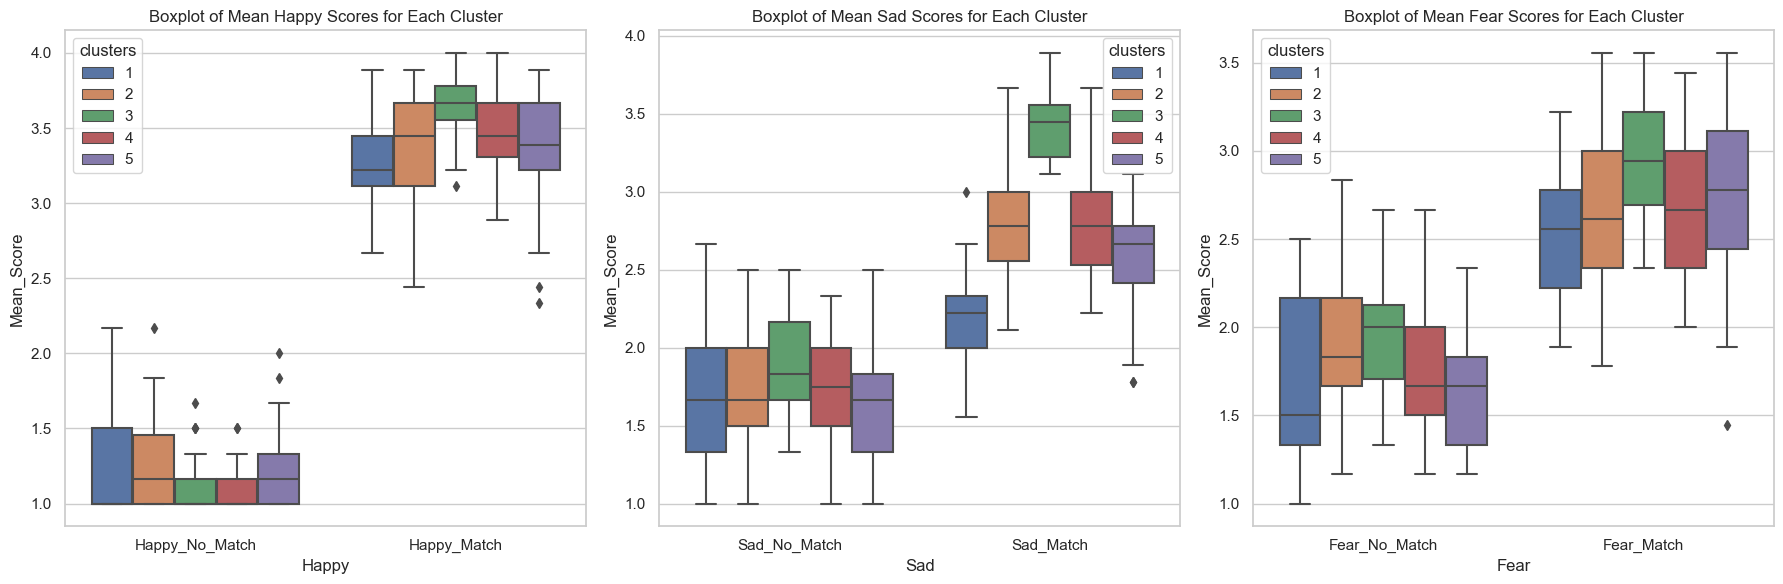

In [54]:
#Boxplots tasks
predictive_plots.create_boxplot_emotions(data,cluster_data_sad1)


#### Sad No Match

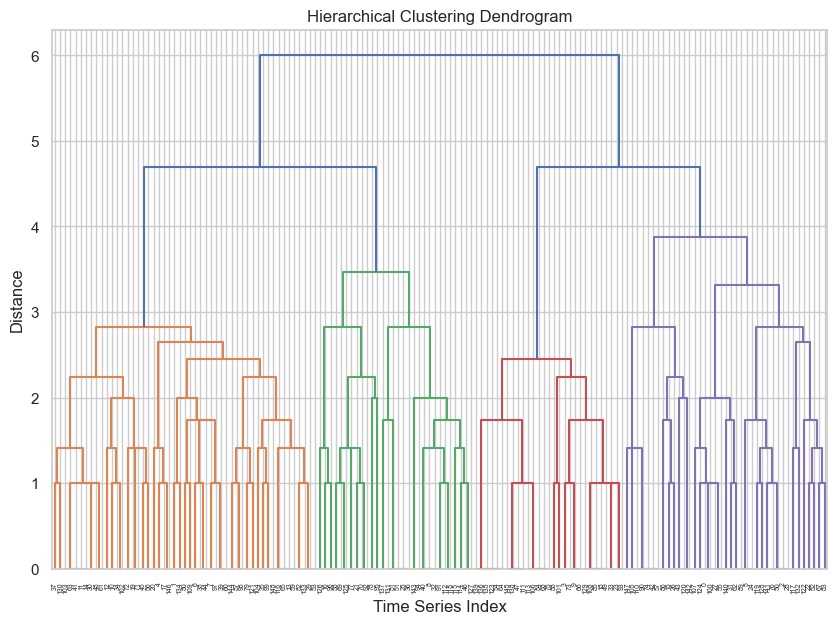

In [55]:
ts_data = temporal_sad_0.drop(["Subject ID"], axis=1).to_numpy()
Z = predictive_clustering.hierarchical_clustering_ts_linkage([ts_data],dtw.distance_matrix_fast,params=params)

4 clusters can be seen using 4 as the cut-off distance between clusters.

In [56]:
params_clust = {'Z':Z,'t':4,'criterion':'maxclust'}
cluster_data_sad0 = predictive_clustering.clustering(temporal_sad_0.copy(),fcluster, params=params_clust)



print("Silhouette score:",silhouette_score(data.drop("Subject ID",axis=1),cluster_data_sad0["clusters"],metric="manhattan"))
print("Davies-Bouldin score:",davies_bouldin_score(data.drop("Subject ID",axis=1),cluster_data_sad0["clusters"]))



Silhouette score: 0.007553423205880923
Davies-Bouldin score: 4.9131225857099


In [57]:
name_output = f"time_series_sad_no_match.docx"
new_data = pd.merge(scales.copy(), cluster_data_sad0.copy(), right_on='Subject ID', left_on='EPRIME_CODE')
new_data.drop("Subject ID", axis=1, inplace=True)

df = utils.filter_data(new_data)

utils.create_word(df, list_metrics, name_output)

In [58]:
output_name = f'Clusters_TimeSeries/time_series_predictive_processing_sad_non_match_clusters.xlsx'
utils.export_clusters_df(cluster_data_sad0.copy(),output_name)



The clusters have similar distances. It can be seen that cluster 3 has a lower score for scenarios where negative emotions are present. Nonetheless, the differences are mainly present in the non-matching sadness scenarios and are barely present in the rest, which shows that it does not cluster well.  

In [59]:
#Length cluster
predictive_clustering.length_cluster(cluster_data_sad0)


,Cluster,Count
0,1,51
1,2,30
2,3,29
3,4,39


In [60]:
#Means tasks
utils.create_mean_tasks(data,cluster_data_sad0)


,Cluster,Happy_0,Happy_1,Sad_0,Sad_1,Fear_0,Fear_1
0,4.0,1.264957,3.524217,1.811966,2.840456,1.982906,2.760684
1,1.0,1.215686,3.418301,1.764706,2.825708,1.754902,2.742919
2,3.0,1.189655,3.268199,1.339080,2.574713,1.632184,2.513410
3,2.0,1.166667,3.440741,1.933333,2.770370,1.822222,2.788889


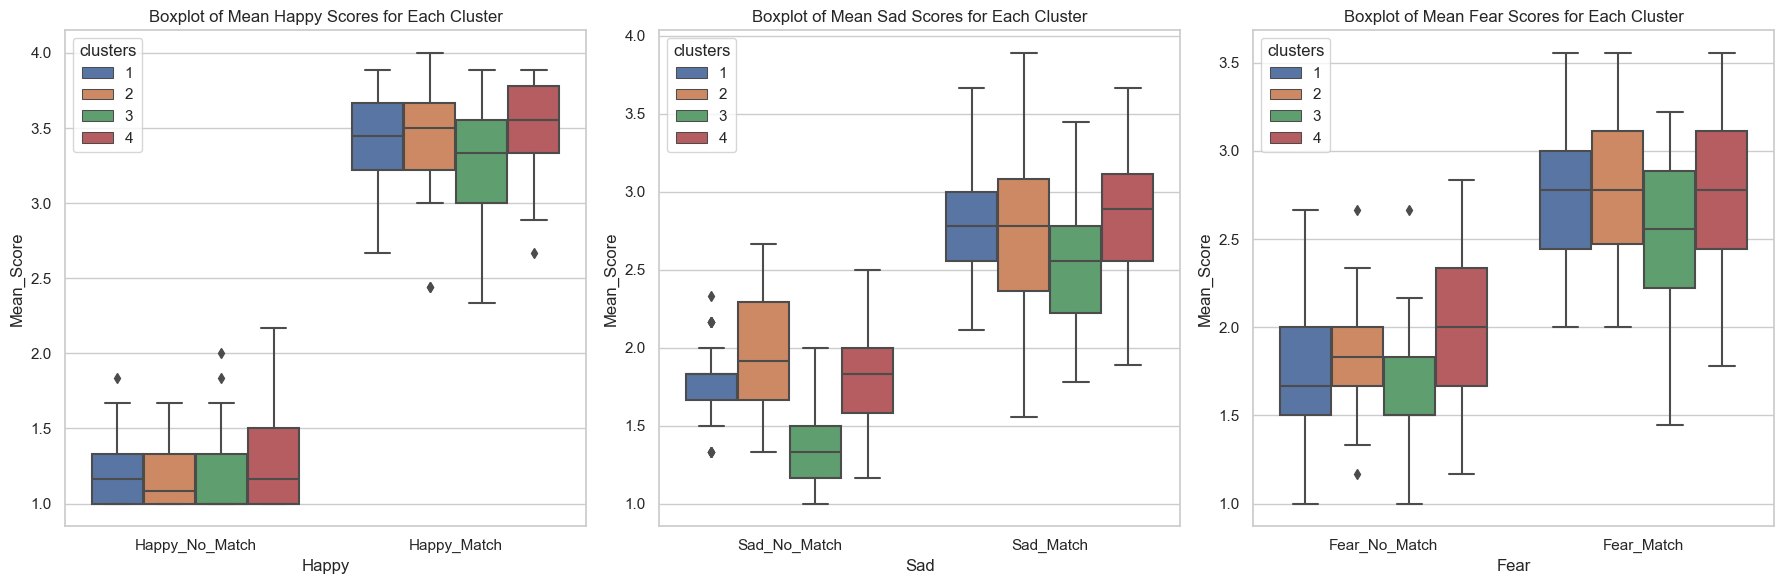

In [61]:
#Boxplots tasks
predictive_plots.create_boxplot_emotions(data,cluster_data_sad0)


## Cluster averaged sum of distances NORMALIZAR


It would be ideal to be able to compare directly the time series from each subject without making any modifications. While this is not possible as the order of trials are randomized (and DTW would not help here as the distance between same scenarios can be huge), we can combine the distances matrices created from each time series. Even though we could give weights to each time series based on the results obtained from them, the safest option to begin with is to do the averaged sum of the distances, and then create the clusters from the averaged matrix.

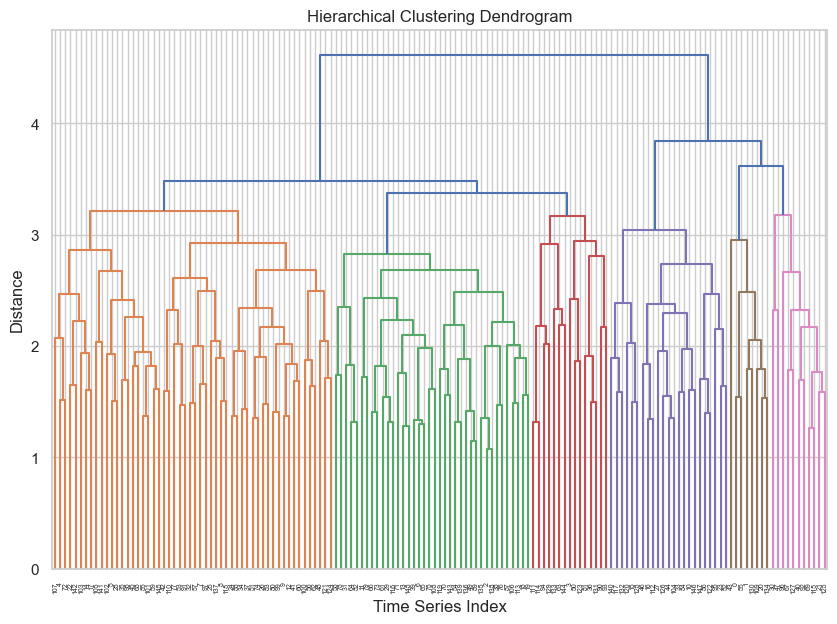

In [62]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform


list_timeseries = [temporal_sad_0.drop(["Subject ID"], axis=1).to_numpy(),temporal_sad_1.drop(["Subject ID"], axis=1).to_numpy(),temporal_fear_0.drop(["Subject ID"], axis=1).to_numpy(),temporal_fear_1.drop(["Subject ID"], axis=1).to_numpy(),temporal_happy_0.drop(["Subject ID"], axis=1).to_numpy(),temporal_happy_1.drop(["Subject ID"], axis=1).to_numpy()]

Z= predictive_clustering.hierarchical_clustering_ts_linkage(list_timeseries,dtw.distance_matrix_fast,params=params)


In this scenario we lower the distance cut-off from 4 to a value near 3 (we use the one generated by the dendrogram itself, that it is around 3.2 based on the average distance between clusters and it produces a reasonable number of clusters). We end up with 6 clusters, where it can be observed that they will differ vastly on size.

In [63]:
params_clust = {'Z':Z,'t':6,'criterion':'maxclust'}
cluster_data_average = predictive_clustering.clustering(data.copy(),fcluster, params=params_clust)

print("Silhouette score:",silhouette_score(data.drop("Subject ID",axis=1),cluster_data_average["clusters"],metric="manhattan"))
print("Davies-Bouldin score:",davies_bouldin_score(data.drop("Subject ID",axis=1),cluster_data_average["clusters"]))


Silhouette score: 0.003337060193631856
Davies-Bouldin score: 4.53135621988024


In [64]:
name_output = f"time_series_all.docx"
new_data = pd.merge(scales.copy(), cluster_data_average.copy(), right_on='Subject ID', left_on='EPRIME_CODE')
new_data.drop("Subject ID", axis=1, inplace=True)

df = utils.filter_data(new_data)

utils.create_word(df, list_metrics, name_output)

In [65]:
output_name = f'Clusters_TimeSeries/time_series_predictive_processing_all_emotions_clusters.xlsx'
utils.export_clusters_df(cluster_data_sad0.copy(),output_name)


We will analyze each cluster, to see whether there are interesting differences or not.
- cluster 1: Considerable size, low scores for negative matching emotions in general, average score for the negative non-matching, in the higher bound for non-matching happiness.
- cluster 2: Lowest score for non-matching scenarios, but also a low score for matching. The score is lower for negative emotions in the matching scenarios.
- cluster 3: Highest score for non-matching happiness, and also the lowest score for matching scenarios (with quite a gap for happiness and sadness). Low sample size. Seems to contain outliers.
- cluster 4: High score for matching scenarios, also high score for non-matching negative scenarios (most likely giving a high score when it is the other negative emotion) #TODO: Inspect if this is the case
- cluster 5: Highest score for all scenarios, very low sample size.
- cluster 6: High score for negative non-matching scenarios, also a high score for matching scenarios. Similar scores to cluster 4 except for matching happiness. Seems to have outliers. 

In [66]:
#Length cluster
predictive_clustering.length_cluster(cluster_data_average)

,Cluster,Count
0,1,54
1,2,38
2,3,15
3,4,23
4,5,8
5,6,11


In [67]:
#Means tasks
utils.create_mean_tasks(data,cluster_data_average)


,Cluster,Happy_0,Happy_1,Sad_0,Sad_1,Fear_0,Fear_1
0,5.0,1.500000,3.652778,2.083333,3.416667,2.187500,3.138889
1,2.0,1.021930,3.342105,1.517544,2.634503,1.491228,2.453216
2,3.0,1.466667,3.074074,1.588889,2.333333,1.900000,2.444444
3,1.0,1.311728,3.500000,1.740741,2.699588,1.802469,2.761317
4,4.0,1.028986,3.603865,1.869565,3.120773,2.057971,2.932367
5,6.0,1.227273,3.232323,2.030303,2.969697,1.954545,2.959596


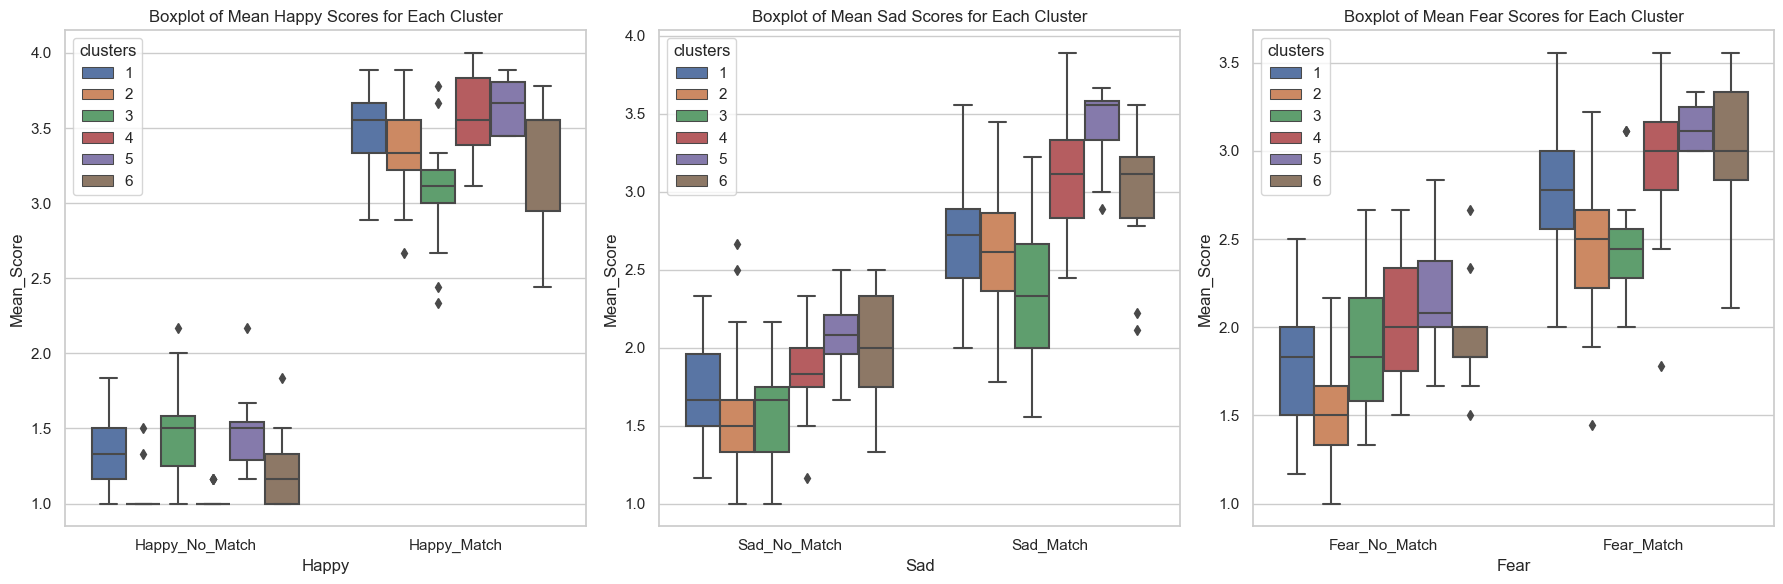

In [68]:
#Boxplots tasks
predictive_plots.create_boxplot_emotions(data,cluster_data_average)


### Prediction on Rating0 differenciated by Match and Emotion on RETOS & BEBRASK using Moving Average Time Series


In [55]:
data = pd.read_excel("RETOS_BEBRASK_Rating0_Time_MA_Series.xlsx")
data

,Subject ID,Happy_0_MA_0,Happy_0_MA_1,Happy_0_MA_2,Happy_0_MA_3,Happy_1_MA_0,Happy_1_MA_1,Happy_1_MA_2,Happy_1_MA_3,Happy_1_MA_4,...,Fear_0_MA_1,Fear_0_MA_2,Fear_0_MA_3,Fear_1_MA_0,Fear_1_MA_1,Fear_1_MA_2,Fear_1_MA_3,Fear_1_MA_4,Fear_1_MA_5,Fear_1_MA_6
0,PREDWELL_RETOS-1001-1,2.000000,1.000000,1.000000,1.000000,4.000000,4.000000,3.666667,3.666667,3.666667,...,1.666667,1.000000,1.666667,2.666667,2.000000,2.666667,3.000000,3.333333,3.333333,3.333333
1,PREDWELL_RETOS-1002-1,1.666667,1.666667,1.666667,1.000000,3.666667,4.000000,4.000000,4.000000,3.666667,...,3.000000,2.333333,1.666667,2.333333,2.666667,3.333333,3.666667,3.000000,3.000000,3.000000
2,PREDWELL_RETOS-1003-1,1.000000,1.000000,1.000000,1.000000,3.333333,3.666667,3.666667,3.333333,3.000000,...,1.333333,1.666667,2.000000,2.333333,2.333333,2.333333,2.000000,1.666667,2.000000,2.333333
3,PREDWELL_RETOS-1004-1,1.666667,2.333333,2.666667,2.000000,2.333333,2.333333,1.333333,1.666667,2.333333,...,1.333333,2.333333,2.333333,3.000000,2.666667,2.333333,2.333333,2.666667,2.000000,2.000000
4,PREDWELL_RETOS-1005-1,1.000000,1.000000,1.333333,1.333333,3.666667,3.333333,3.666667,3.333333,3.666667,...,2.333333,3.000000,2.000000,2.000000,2.333333,2.666667,3.000000,3.333333,3.333333,3.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,PREDWELL_RETOS-5-1,1.666667,1.333333,1.000000,1.000000,3.666667,3.333333,3.000000,2.666667,3.333333,...,2.666667,2.000000,1.000000,2.000000,2.333333,3.333333,3.000000,3.333333,2.666667,2.333333
145,PREDWELL_RETOS-6-1,1.333333,1.333333,1.000000,1.000000,3.333333,2.666667,2.666667,2.666667,3.666667,...,2.666667,2.666667,2.000000,2.000000,2.666667,2.666667,3.000000,2.333333,3.000000,3.333333
146,PREDWELL_RETOS-7-1,1.000000,1.000000,1.000000,1.000000,3.000000,3.333333,3.000000,3.666667,3.333333,...,2.000000,1.666667,2.666667,2.333333,2.333333,3.333333,3.000000,3.000000,3.000000,3.000000
147,PREDWELL_RETOS-8-1,1.000000,1.000000,1.000000,1.000000,3.000000,2.333333,2.000000,2.666667,3.333333,...,3.000000,3.000000,2.666667,3.333333,3.333333,3.000000,3.000000,2.666667,2.333333,2.000000


In [ ]:
temporal_happy_0 = data[["Subject ID","Happy_0_MA_0","Happy_0_MA_1","Happy_0_MA_2","Happy_0_MA_3"]]
temporal_happy_1 = data[["Subject ID","Happy_1_MA_0","Happy_1_MA_1","Happy_1_MA_2","Happy_1_MA_3","Happy_1_MA_4","Happy_1_MA_5","Happy_1_MA_6"]]
temporal_fear_0 = data[["Subject ID","Fear_0_MA_0","Fear_0_MA_1","Fear_0_MA_2","Fear_0_MA_3"]]
temporal_fear_1 = data[["Subject ID","Fear_1_MA_0","Fear_1_MA_1","Fear_1_MA_2","Fear_1_MA_3","Fear_1_MA_4","Fear_1_MA_5","Fear_1_MA_6"]]
temporal_sad_0 = data[["Subject ID","Sad_0_MA_0","Sad_0_MA_1","Sad_0_MA_2","Sad_0_MA_3"]]
temporal_sad_1 = data[["Subject ID","Sad_1_MA_0","Sad_1_MA_1","Sad_1_MA_2","Sad_1_MA_3","Sad_1_MA_4","Sad_1_MA_5","Sad_1_MA_6"]]

## Hierarchical Clustering using Dynamic Time Warping

#### Happy Match

In [ ]:
time_series_data = temporal_happy_1.drop(["Subject ID"], axis=1).to_numpy()
time_series_data = time_series_data.astype(np.float64)
# Convert distance_matrix to float, if it's not already

distance_matrix = dtw.distance_matrix_fast(time_series_data)

distance_matrix = distance_matrix.astype(np.float64)

condensed_dist_matrix = squareform(distance_matrix)
Z = linkage(condensed_dist_matrix, method='complete')

# Step 5: Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Time Series Index')
plt.ylabel('Distance')
plt.show()

In [ ]:
clusters_happy_match = fcluster(Z, 2, criterion='maxclust')


#### Happy Non Match

In [ ]:
time_series_data = temporal_happy_0.drop(["Subject ID"], axis=1).to_numpy()
time_series_data = time_series_data.astype(np.float64)
# Convert distance_matrix to float, if it's not already
#test
distance_matrix = dtw.distance_matrix_fast(time_series_data)

distance_matrix = distance_matrix.astype(np.float64)

condensed_dist_matrix = squareform(distance_matrix)
Z = linkage(condensed_dist_matrix, method='complete')

# Step 5: Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Time Series Index')
plt.ylabel('Distance')
plt.show()


In [ ]:
clusters_happy_non_match = fcluster(Z, 3, criterion='maxclust')

#### Fear Match

In [ ]:
time_series_data = temporal_fear_1.drop(["Subject ID"], axis=1).to_numpy()
time_series_data = time_series_data.astype(np.float64)
# Convert distance_matrix to float, if it's not already

distance_matrix = dtw.distance_matrix_fast(time_series_data)

distance_matrix = distance_matrix.astype(np.float64)

condensed_dist_matrix = squareform(distance_matrix)
Z = linkage(condensed_dist_matrix, method='complete')

# Step 5: Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Time Series Index')
plt.ylabel('Distance')
plt.show()


In [ ]:
clusters_fear_match = fcluster(Z, 3, criterion='maxclust')


#### Fear Non Match


In [ ]:
time_series_data = temporal_fear_0.drop(["Subject ID"], axis=1).to_numpy()
time_series_data = time_series_data.astype(np.float64)
# Convert distance_matrix to float, if it's not already

distance_matrix = dtw.distance_matrix_fast(time_series_data)

distance_matrix = distance_matrix.astype(np.float64)

condensed_dist_matrix = squareform(distance_matrix)
Z = linkage(condensed_dist_matrix, method='complete')

# Step 5: Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Time Series Index')
plt.ylabel('Distance')
plt.show()



In [ ]:
clusters_fear_no_match = fcluster(Z, 3, criterion='maxclust')

#### Sad Match

In [ ]:
time_series_data = temporal_sad_1.drop(["Subject ID"], axis=1).to_numpy()
time_series_data = time_series_data.astype(np.float64)
# Convert distance_matrix to float, if it's not already

distance_matrix = dtw.distance_matrix_fast(time_series_data)

distance_matrix = distance_matrix.astype(np.float64)

condensed_dist_matrix = squareform(distance_matrix)
Z = linkage(condensed_dist_matrix, method='complete')

# Step 5: Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Time Series Index')
plt.ylabel('Distance')
plt.show()

In [ ]:
clusters_sad_match = fcluster(Z, 3, criterion='maxclust')


#### Sad No Match

In [ ]:
time_series_data = temporal_sad_0.drop(["Subject ID"], axis=1).to_numpy()
time_series_data = time_series_data.astype(np.float64)
# Convert distance_matrix to float, if it's not already

distance_matrix = dtw.distance_matrix_fast(time_series_data)

distance_matrix = distance_matrix.astype(np.float64)

condensed_dist_matrix = squareform(distance_matrix)
Z = linkage(condensed_dist_matrix, method='complete')

# Step 5: Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Time Series Index')
plt.ylabel('Distance')
plt.show()

In [ ]:
clusters_sad_no_match = fcluster(Z, 3, criterion='maxclust')